In [1]:
import math
import numpy as np
import matplotlib as plt
%matplotlib inline

> Notes
- **Micrograd** is a library that Andrej released on GitHub, which is an *Autograd* engine (short for automatic gradient). It implements backpropagation
	- Scalar valued autograd engine, so it's working on the level of individual scalars (like -4 and 2) and we're taking NNs and breaking them down all the way to these "atoms" of individual scalars
	- Allows you to build out mathematical expressions; add, multiple, raise them to a constant power, offset by 1, negate, squash at 0 (.relu()), square, divide by constant, divide, etc
    - Figuring out the derative of a, `print(f'{a.grad:.4f}')`, and b, `print(f'{b.grad:.4f}')`, is important because it's telling us how a and b are affecting g, `g.backward()`, through the chain rule mathematical expression of backpropagation
	- **How will g respond if a and b get tweaked a bit a tiny amount in a positive direction:** 
		- a.grad = 138.8, so, if slightly nudge a and make it slightly larger (the value), 138 is telling us that g will grow and that slope of that growth is going to be 138
		- b.grad = 645.6, so, the slope of growth of b is going to be 645.6
- **What is backpropagation?** An algorithm that allows you to efficiently evaluate the gradient of some kind of loss function with respect to the weights of a NN. It's the mathematical core of any modern deep NN library (PyTorch, JAX, etc)
	- We can iteratively tune the weights of the NN to minimize the loss function to improve the accuracy of the NN
- NNs are just mathematical expressions like the one above but can be slightly less crazy
	- Takes the input data (as input) and the weights of a NN (as input) and its mathematical expression and the output are your predictions of your NN or loss function
	- NNs are a certain class of mathematical expressions but back propagation is more general, it doesn't care about NNs at all, it only tells us about arbitrary mathematical expressions and we happen to use that machinery for training of NNs
- If you want to train bigger networks you have to be using tensors, basically taking scale values, packaging up into tensors (arrays of these scalars), because we have these large arrays, we're making operations on, allows us to take advantage of the parallelism in a computer aka run faster
	- Just for efficiency but the math is the same as back propagation
- **Rare Andrej take:** Micrograd is what you need to train your networks and everything else is just efficiency
- Looking into the micrograd folder within GitHub:
	- Only two files: engine.py and nn.py
	- engine.py doesn't know anything about neural nets (autograd engine that gives you the power of NNs). 100 lines of code
	- nn.py is the entire NNs library on top of micrograd (autograd engine). Defines what is a neuron, layer of neurons, and multi-layer perceptron (MLP - sequence of layers of neurons). 150 lines of code

**Neural networks are massive mathematical expressions, we need some data structures that maintain these expressions**

The class value has the full mathematical expression. This data structure knows exactly how each value came to be by word expression and from what other values:

In [4]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # Returns a string representation of the Value object
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Defines the addition operation for Value objects
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # Defines the multiplication operation for Value objects
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label= 'L'
L
# d._prev # ((a*b), c) = {Value(data=-6.0), Value(data=10.0)}
# d._op = '+'

Value(data=-8.0)

This class nicely visualizes the expressions that are being built out:

The cell below creates a new function, draw_dot, that we can call on a root node and then it visualizes it

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data, ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

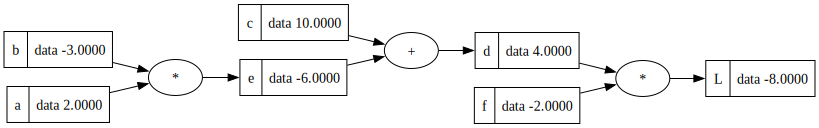

In [6]:
draw_dot(L) # output of the forward pass composed of scalar values is -8

> Notes
- Back propagation = reverse from L and calculate the gradient from all the intermediate values = for every single value we are going to compute the derivative of that node with respect to L
- Derivative of L with respect to L is 1
- Derivative of L with respect to F, D, E, C, B, and A
- In the NN setting you'd be interested in the derivative of this loss function, L, with respect the weights of a NN
- We have the variables, A, B, C, D, E, F but will eventually represent the weights of a NN so we'll need to know how the weights are impacting the loss function = derivative of the output with respect to some of its leaf nodes and the leaf nodes will be the weights of the NN while the other leaf nodes will be the data itself but we will usually not want or use the derivative of the loss function with respect to data because the data is fixed but the weights will be iterated on using the gradient information